In [3]:
import numpy as np
from ase.io import read
from ase.cluster import Decahedron
from dask.distributed import Client

from abtem import GridScan, AnnularDetector, Probe, Potential, FrozenPhonons

import os
os.environ['MKL_NUM_THREADS'] = '1'

# abTEM and Dask

Parallel computation in abTEM whether it is running on a laptop or a High Performance Computing cluster goes through [Dask](https://dask.org/). Some knowledge of Dask may be required to run abTEM effectively on large multi-CPU/GPU systems, however, if you are just running abTEM on your own computer, this tutorial gets you started. If you want a quick introduction to Dask, we recommend [this](https://www.youtube.com/watch?v=nnndxbr_Xq4&t=66s) short youtube video.

## Lazy computations and task graphs

Computations in abTEM can be _lazy_ (otherwise called _delayed_), as an example this means that we can create the tasks required for building a probe wave function without actually running that calculation.

In [4]:
probe = Probe(energy=80e3, extent=10, gpts=256, semiangle_cutoff=20)

build_probe = probe.build(lazy=True)

build_probe.array

dask.array<calculate_probes, shape=(1, 256, 256), dtype=complex64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>

The result is a [Dask array](https://docs.dask.org/en/stable/array.html). If you want the NumPy array you have to run the `.compute` method.

In [5]:
build_probe.compute()

type(build_probe.array)

[########################################] | 100% Completed |  0.1s


numpy.ndarray

The multislice algorithms requires running several interdependent tasks, we call this a [task graph](https://docs.dask.org/en/stable/graphs.html). Below we create the task graph for running the multislice algorithm several times with different frozen phonon configurations over a grid of initial probe wave functions. The result is a grid of 2d grids of 2d wave functions, which can be represented as a 5d NumPy array. Note that we are setting `lazy=True` and hence the calculation is _not being run_.

In [7]:
atoms = Decahedron('Au', 2, 2, 1)
atoms.rotate(30, 'x', center='cop')
atoms.center(vacuum=1)

potential = Potential(FrozenPhonons(atoms, 4, {'Au': 0.1}), slice_thickness=2)

gridscan = GridScan()

exit_waves = probe.multislice(potential, gridscan, chunks='auto', lazy=True)

In the delayed `Dask` array below, the first dimension represents the frozen phonons, the next two dimensions are the scan dimensions and the last two dimensions representes the spatial frequencies (or scattering angles) in x and y.

In [8]:
exit_waves.array

dask.array<stack, shape=(4, 31, 30, 256, 256), dtype=complex64, chunksize=(1, 16, 15, 256, 256), chunktype=numpy.ndarray>

If you have [graphviz](https://docs.dask.org/en/stable/graphviz.html) installed you can visualize the task graph as we do below.

In [9]:
#exit_waves.visualize_graph(node_attr={'fontsize':'100.0'})

Dask arrays are composed of many NumPy arrays (or CuPy arrays on gpu). In this example, the full Dask array is 1.82 gb of memory, however it is split into smaller NumPy arrays called _chunks_ which are each 120 mb. Your system could probably hold the entire 5d array in memory, however, if the simulation was larger this might not be true. 

In practice the entire 5d array does not have to be in memory at any point. Every time a new _chunk_ of the 5d array is created it can be reduced to a smaller size by applying a detector configuration and by applying partial redcutions accross the froxen phonon dimenion.

In [10]:
diffraction_patterns = exit_waves.diffraction_patterns()

measurement = diffraction_patterns.integrate_radial(50, 140).mean(0)

measurement.array

dask.array<mean_agg-aggregate, shape=(31, 30), dtype=float32, chunksize=(16, 15), chunktype=numpy.ndarray>

We can finally call compute, which will trigger the calculation to start (should be about 10 s on an 8-core CPU).

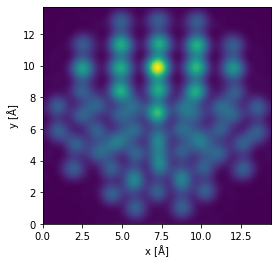

In [12]:
measurement.compute()

measurement.interpolate(.1).show();

The result above can also be obtained using the `.scan` method and the `AnnularDetector` and it will run slightly faster, with lower memory consumption, since it allows us to do some addtional optimization

In [13]:
detector = AnnularDetector(inner=50, outer=150, ensemble_mean=True)

detector = PixelatedDetector()

measurement = probe.scan(gridscan, detector, potential, chunks='auto', lazy=True)

In [14]:
measurement.compute()

[########################################] | 100% Completed | 11.6s


## The task scheduler

After the task graph is generated, it has to be executed on parallel hardware, this is the job of a [task scheduler](https://docs.dask.org/en/stable/scheduling.html). The execution of abTEM simulation can be customized by passing the same arguments avaiable for Dask collections. For example:

In [16]:
measurement = probe.scan(gridscan, detector, potential, chunks='auto', lazy=True)

measurement.compute(n_workers=4)

Even if you are running abTEM locally you can still use the dask distributed scheduler.

In [18]:
from dask.distributed import Client

client = Client(n_workers=4)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62569 instead
  warnings.warn(


The distributed scheduler provides a [diagnotic dashboard](https://docs.dask.org/en/latest/diagnostics-distributed.html) containing many plots and tables with live information about the simulation.

The dashboard is typically served at http://localhost:8787/status, but may be served elsewhere if this port is taken. If you are using Jupyter Lab the [Dask labextension](https://github.com/dask/dask-labextension) provides the same information more conveniently.

In [19]:
client

Client Scheduler: tcp://127.0.0.1:62572 Dashboard: http://127.0.0.1:62569/status,Cluster Workers: 4 Cores: 16 Memory: 31.93 GiB


Click the link above, then run the code below to see the dashboard visualization of the computation.

In [20]:
measurement = probe.scan(gridscan, detector, potential, chunks='auto', lazy=True)
measurement.compute()

abTEM can be deployed on various distributed systems following [these guidelines](https://docs.dask.org/en/stable/how-to/deploy-dask-clusters.html). Look [here](https://docs.dask.org/en/stable/how-to/deploy-dask/hpc.html) for instructions on deployment on High Performance Computers, using tools like MPI, or job schedulers like SLURM.
We maintain a [Docker image](https://hub.docker.com/repository/docker/jacobjma/abtem-dask) that might be useful if your HPC cluster supports singularity.

In [32]:
#cluster = LocalCUDACluster()
#client = Client(cluster)

If you are 